# Write a custom dataloader from scratch

In the world of machine learning coming late has a few disadvantages and few advantages. Advantages is you have different approaches of people designing models in there own way. There are a lot of duplicate libraries across tools and platforms. 

When you talk about disadvantages is there are lot of alogorithms and techniques already standardised, so that it is becomes easy for non-machine learners you understand it. I see it as a disadvantage as I dont like abstractions/black boxes. As being a 10 years experience in this industry. If a production issue ends up in your bag you need to be able to debug it end to end, each component used and why it was used.

## Data 
So lets talk about something which is necessary for model training. It is data. But nowadays it is also getting standardised and coming as a wrapper example `torch.utils.data.Dataset`

However if you are building something from scratch for your confidential data. It becomes a difficult task to implement it if you are used to these Datasets.

So lets unravial these concepts and write a scalable code to create a custom dataset using pytorch

In [21]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import multiprocessing

## Dataset

Here I have taken imagenet-mini dataset present in Kaggle to implement this.

https://www.kaggle.com/datasets/ifigotin/imagenetmini-1000

I have downloaded a zip and using the extracted data to create a dataset



In [22]:
BASE_DIR = os.path.join('..','Neural Networks for Images')

image_path = os.path.join(BASE_DIR,'imagenet-mini')
labels_path = os.path.join(BASE_DIR, 'words.txt')

BASE_DIR = os.path.join('.')

image_path = os.path.join(BASE_DIR,'imagenet-mini')
labels_path = os.path.join(BASE_DIR, 'words.txt')

class ImageNetMiniDataset(Dataset):
    def __init__(self, annotations_file, img_dir, resize=(224,224), train=True, transform=None, target_transform=None):
        self.img_labels = self.read_labels(annotations_file)
        self.img_dir_paths = self.read_image_paths(img_dir,train)
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        self.resize_dim = resize

    def read_labels(self,path):
        labels_dict = dict()
        label_value = 0
        with open(path, 'r') as f:
            while True:
                label = f.readline()
                if len(label) == 0:
                    break
                label = label.split('\t')
                labels_dict[label[0]] = label[1]
                label_value += 1
        return labels_dict

    def read_image_paths(self,img_dir,train):
        sub_path = 'train' if train else 'val'
        result = []
        path = os.path.join(img_dir, sub_path)
        for current in os.listdir(path):
            current_path = os.path.join(path,current)
            for current_file in os.listdir(current_path):
                result.append((os.path.join(current_path,current_file),current))
        return result

    def __len__(self):
        return len(self.img_dir_paths)

    def __getitem__(self, idx):
        img_path, label = self.img_dir_paths[idx]
        image = cv2.resize(cv2.imread(img_path), self.resize_dim, interpolation=cv2.INTER_AREA)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

transform = transforms.Compose(
    [
        transforms.ToTensor()
    ]
)

## LazyDataloader
Here I use lazydataloader to read the files and put it in memeory only when the __next__ method is called. So that it loads only the data required during training the data. I am also using thread pool to pull data independently by num workers. Which makes it a little faster in terms of the reads happening. This can be replaced with multi-cluster code to read data per worker in a cluster and then use it in model training.

However model training cannot be parallel as the parameters get modified based on the data coming in and training it. Which makes it a bottleneck however there are few techniques used in the world of semi-supervised learning. Let me talk briefly about it. When we have a large unlabeled dataset we try to make use of the unlabeled part in the labeled part. This is called semi-supervised learning. Here we train the model with the unlabeled part first and lets itself find predictions from the data. These are called pseudo-labeling (This word was coined in "Pesudo-label: The simple and efficient semi-supervised learning method for deep neural networks").As the predictions cannot be said correct in terms of how they were obrained but can be called pseudo correct. However this approach can introduce bias based on the unlabeled data. There are concepts of co-training and tri-training where we train multiple models separately on data and use its predictions to infer the data or maybe provide data with labels.

In [23]:
class LazyDataLoader:

    def __init__(self, dataset, batch_size=10, shuffle=False, num_workers=0):
        self.dataset = dataset
        self.batch_size = batch_size
        # self.shuffle = shuffle
        self.num_workers = num_workers
        self.total_batches = len(dataset)//batch_size + (0 if len(dataset)%batch_size == 0 else 1)
        self.extras = 0 if len(dataset)%batch_size == 0 else len(dataset)%batch_size
        self.label_map = dict()
    
    def __len__(self):
        return self.total_batches
    
    def __iter__(self):
        counter = np.arange(self.total_batches*self.batch_size)
        np.random.shuffle(counter)
        self.counter = counter.reshape((self.total_batches,self.batch_size,-1))
        # print('batch-shape : ',self.counter.shape)
        self.current_batch = 0
        return self
    
    def fetch_data(self, index):
      image,label = self.dataset[index[0]]
      return (image,self.getLabelFromMap(label))
    
    def __next__(self):
        if self.current_batch >= self.counter.shape[0]:
            raise StopIteration
        if self.num_workers != 0:
            thread_pool = multiprocessing.Pool(self.num_workers)
            tensors_per_batch = thread_pool.map(self.fetch_data, [indexes for indexes in self.counter[self.current_batch] if indexes < len(self.dataset)])
            x_all = []
            y_all = []
            for values in tensors_per_batch:
                x_all.append(values[0])
                y_all.append(values[1])
            self.current_batch += 1
            return torch.stack(x_all),torch.LongTensor(y_all)
        else:
            # for current_batch in range(self.total_batches):
            x_all = []
            y_all = []
            for i in self.counter[self.current_batch]:
                if i >= len(self.dataset):
                    continue
                x,y = self.fetch_data(i)
                x_all.append(x)
                y_all.append(y)
            self.current_batch += 1
            # print(self.current_batch)
            return torch.stack(x_all),torch.LongTensor(y_all)
        raise StopIteration

    def getLabelFromMap(self, y):
        c_label = None
        if y in self.label_map:
            c_label = self.label_map[y]
        else:
            c_label = len(self.label_map)
            self.label_map[y] = c_label
        return c_label

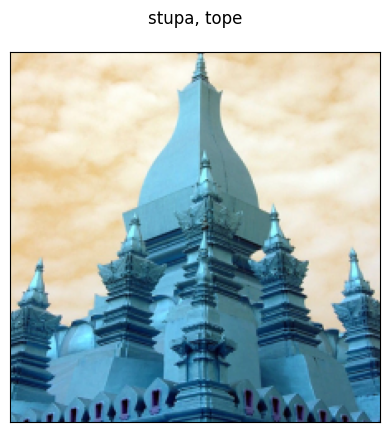

In [40]:
image_net_train_dataset = ImageNetMiniDataset(labels_path,image_path,resize=(224,224),transform=transform)
image_net_test_dataset = ImageNetMiniDataset(labels_path,image_path,resize=(224,224),train=False, transform=transform)
train_iter = LazyDataLoader(image_net_train_dataset, batch_size=1000, shuffle=True, num_workers=0)
# test_iter = LazyDataLoader(image_net_test_dataset, batch_size=100, num_workers=multiprocessing.cpu_count())
i = 1
for x,y in train_iter:  
    image = x[0]
    label = y[0]
    reverse_dict = {v : k for k,v in train_iter.label_map.items()}
    plt.subplot(1, 1, i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.permute(1,2,0))

    key = reverse_dict[label.int().item()]
    plt.title(image_net_train_dataset.img_labels[key])
    if i>=1:
        break
    i+=1
plt.show()
